##**DQN-based Trading Agent**

This project demonstrates how Reinforcement Learning (RL), specifically Deep Q-Networks (DQN),
can be applied to algorithmic trading. Instead of using fixed trading rules, the agent learns
to decide when to Buy, Sell, or Sit by interacting with historical stock data.

Main Workflow:
1. Load stock data (Apple stock here).
2. Perform Exploratory Data Analysis (EDA).
3. Define helper functions (for state representation, formatting, plotting).
4. Implement the Agent class (neural network, memory, action selection, learning).
5. Train the agent through episodes of simulated trading.
6. Visualize trading performance.

Install and import the libraries

In [1]:
# External library for stock market data
!pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from collections import deque
from tensorflow.keras import layers, models, optimizers

###**Data Loading**

This block fetches historical stock price data (Apple in this case),
saves it into a CSV file, and prepares it for analysis and training.

In [2]:
# Download Apple stock as a DataFrame
df = yf.download("AAPL", start="2020-01-01", end="2021-01-01")
df.to_csv("AAPL.csv")   # Save to CSV so train_agent can read it

stock_file = "AAPL.csv"

/tmp/ipython-input-1664186109.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2020-01-01", end="2021-01-01")
[*********************100%***********************]  1 of 1 completed


###**Exploratory Data Ananlysis**

EDA helps us understand the data before training our agent.
We plot stock closing prices, daily returns, and moving averages.
This gives us insights into volatility, trends, and possible features
that could improve the agent's state representation.

In [7]:
def run_eda(stock_file: str) -> None:
    """Run exploratory analysis on the stock data and plot key metrics."""
    # Fix: read dates correctly and ensure numeric Close column
    data = pd.read_csv(stock_file, index_col=0, parse_dates=True)
    data["Close"] = pd.to_numeric(data["Close"], errors="coerce")
    data = data.dropna(subset=["Close"])  # drop rows with invalid values

    # Compute daily returns
    data["Return"] = data["Close"].pct_change()

    # Closing price trend
    plt.figure(figsize=(12, 5))
    plt.plot(data["Close"], label="Closing Price")
    plt.title("Stock Closing Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Daily returns
    plt.figure(figsize=(12, 5))
    plt.plot(data["Return"], label="Daily Return", color="orange")
    plt.title("Daily Returns Over Time")
    plt.xlabel("Date")
    plt.ylabel("Return (%)")
    plt.axhline(0, color="red", linestyle="--", linewidth=1)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Moving averages (trend indicators)
    data["MA10"] = data["Close"].rolling(10).mean()
    data["MA50"] = data["Close"].rolling(50).mean()

    plt.figure(figsize=(12, 5))
    plt.plot(data["Close"], label="Closing Price", alpha=0.5)
    plt.plot(data["MA10"], label="10-Day MA", color="green")
    plt.plot(data["MA50"], label="50-Day MA", color="red")
    plt.title("Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.show()

/tmp/ipython-input-3557095257.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(stock_file, index_col=0, parse_dates=True)


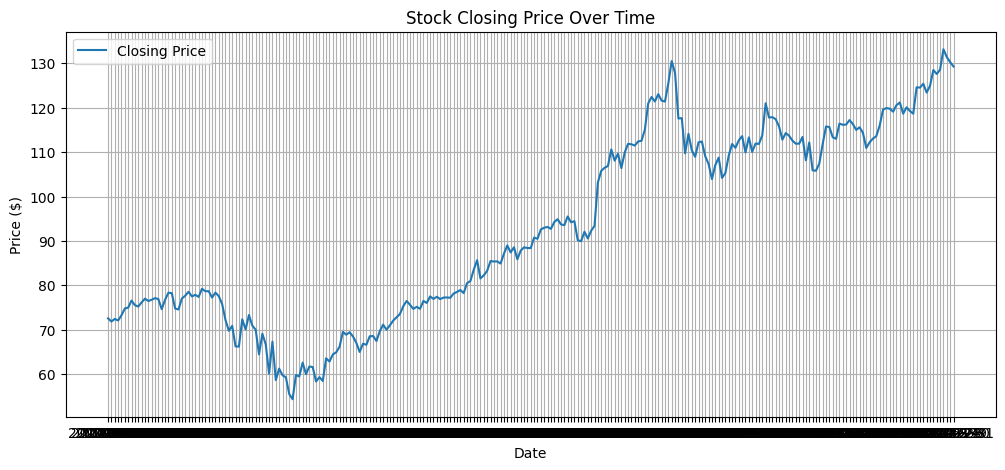

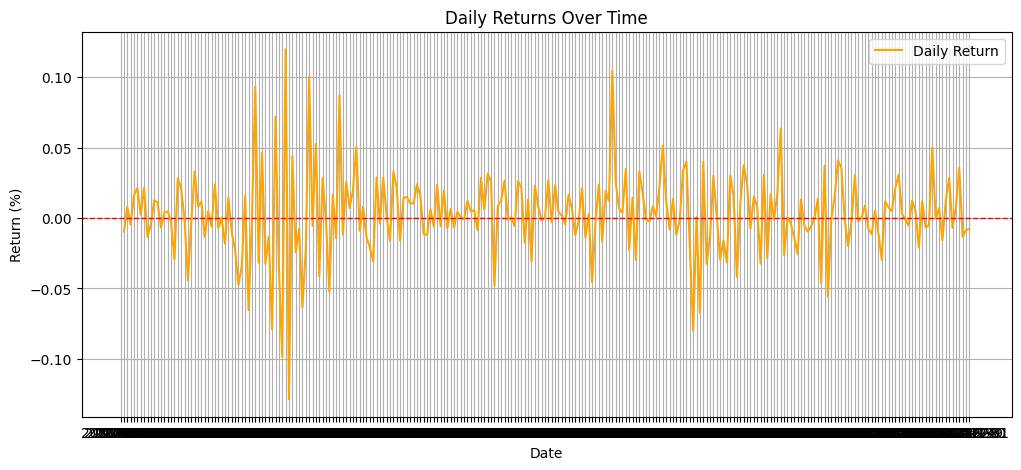

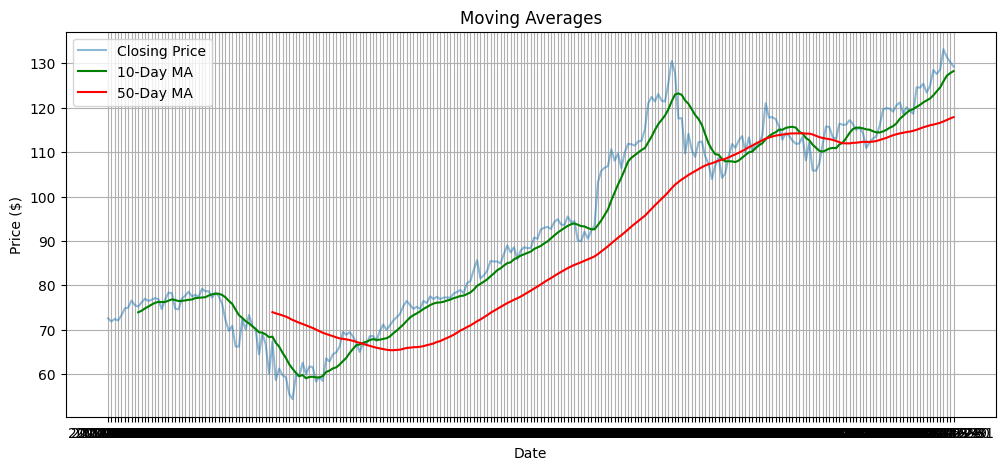

In [8]:
run_eda(stock_file)

###**Helper/ Utility Functions**

Utility functions to help with:
- Normalizing price changes (sigmoid).
- Converting recent prices into state vectors for the agent.
- Formatting profit values for display.
- Plotting trading performance results.

In [9]:
def sigmoid(x: float) -> float:
    """Squash values into (0,1) range using the sigmoid function."""
    return 1 / (1 + math.exp(-x))

In [10]:

def get_state(prices: list, t: int, window: int) -> np.ndarray:
    """Build the agent's market state using recent price differences."""
    start = max(0, t - window + 1)
    block = [prices[0]] * (window - (t - start + 1)) + prices[start:t+1]
    diffs = [sigmoid(block[i+1] - block[i]) for i in range(window - 1)]
    return np.array([diffs])

In [11]:
def format_price(p: float) -> str:
    """Format numeric values as currency strings."""
    return f"{'-' if p < 0 else ''}${abs(p):.2f}"

In [12]:
def plot_profit(profits: list[float], total_profit: float) -> None:
    """Plot profit/loss per trade and display cumulative profit."""
    plt.figure(figsize=(10, 5))
    plt.plot(profits, marker="o")
    plt.axhline(0, color="red", linestyle="--", linewidth=1)
    plt.xlabel("Trade Number")
    plt.ylabel("Profit")
    plt.title(f"Profit per Trade (Total: {format_price(total_profit)})")
    plt.grid(True)
    plt.show()

###**Agent Class**

This class defines the RL agent (trader).
The agent:
- Uses a neural network to approximate Q(s,a) values.
- Balances exploration vs exploitation (epsilon-greedy).
- Stores past experiences in memory.
- Learns using the Bellman equation and experience replay.

Mathematical Context

* State (s): recent price changes (window of days).
* Actions (a): `{0 = Sit, 1 = Buy, 2 = Sell}`.
* Reward (r): profit when selling (0 if loss).
* Q-function:

  $$
  Q(s,a) = \text{expected future reward if taking action } a \text{ in state } s
  $$
* Bellman update:

  $$
  Q_\text{target} =
  \begin{cases}
  r & \text{if done} \\
  r + \gamma \max_{a'} Q(s', a') & \text{otherwise}
  \end{cases}
  $$
* Neural network: approximates $Q(s,a)$ instead of storing large Q-tables.
* Policy (epsilon-greedy):

  * With probability $\epsilon$: pick a random action (exploration).
  * Otherwise: pick $\arg\max Q(s,a)$ (exploitation).
* Experience replay: stores `(s, a, r, s’, done)` and trains on random minibatches.

Key Parameters

* γ (gamma): discount factor for future rewards.
* ε (epsilon): probability of random action, decays over time.



In [13]:

class Agent:
    """A DQN-based trading agent that learns Buy/Sell/Sit strategies."""

    def __init__(self, state_size: int, is_eval: bool = False, model_name: str = ""):
        """Initialize the agent with state size, memory, and parameters."""
        self.state_size = state_size
        self.action_size = 3  # Sit, Buy, Sell
        self.memory = deque(maxlen=200)
        self.inventory: list[float] = []
        self.is_eval = is_eval

        # Learning parameters
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9

        # Neural network model
        self.model = (
            self._build_model()
            if model_name == "" else models.load_model(model_name)
        )

    def _build_model(self) -> models.Sequential:
        """Build a simple feedforward neural network for Q-value approximation."""
        model = models.Sequential([
            layers.Dense(32, input_dim=self.state_size, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(self.action_size, activation="linear")
        ])
        model.compile(loss="mse", optimizer=optimizers.Adam(learning_rate=0.001))
        return model

    def act(self, state: np.ndarray) -> int:
        """Choose an action using epsilon-greedy strategy."""
        if not self.is_eval and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return int(np.argmax(q_values[0]))

    def replay(self, batch_size: int) -> None:
        """Train the neural network on random minibatches of past experiences."""
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

###**Training Loop (`train_agent`)**

The training loop simulates trading on historical stock data and allows the Agent to learn from experience.

Workflow

1. Load data: Read closing prices from CSV.
2. Initialize agent: Create a DQN agent with a given window size.
3. Episodes: Each episode is one full run through the stock data.
4. For each day (time step):

   * Build the current state (recent price changes).
   * Agent chooses an action (Sit, Buy, Sell).
   * If Buy → add stock to inventory.
   * If Sell → calculate profit, assign reward, update total profit.
   * Store experience `(s, a, r, s’, done)` in memory.
   * Train the agent on a random minibatch from memory (experience replay).
5. End of episode: Print cumulative profit.

---

Mathematical Context

* Reward assignment:

  * If Sell is profitable: $r = \text{profit}$.
  * If Sell is a loss: $r = 0$.
* Experience tuple:

  $$
  (s, a, r, s', \text{done})
  $$
* Bellman update (inside replay):

  $$
  Q_\text{target} =
  \begin{cases}
  r & \text{if done} \\
  r + \gamma \max_{a'} Q(s', a') & \text{otherwise}
  \end{cases}
  $$
* Training objective: minimize mean squared error (MSE) between predicted Q-value and target.

---

Key Parameters

* Window size: how many past days form the state.
* Episodes: number of times the full dataset is used for training.
* Batch size: number of past experiences sampled per training step.




The training loop lets the agent interact with historical data,
store experiences, and learn trading strategies by applying the
Bellman equation on replayed experiences across multiple episodes.


In [14]:
def train_agent(stock_file: str, window_size: int, episodes: int = 1, batch_size: int = 16) -> tuple[list[float], float]:
    """Train the DQN trading agent on historical stock prices."""
    # Load data
    data = pd.read_csv(stock_file)
    prices = pd.to_numeric(data["Close"], errors="coerce").dropna().tolist()
    n_steps = len(prices) - 1

    # Initialize agent
    agent = Agent(state_size=window_size)
    trade_profits: list[float] = []
    total_profit = 0.0

    for ep in range(episodes):
        print(f"\n--- Episode {ep + 1}/{episodes} ---")
        state = get_state(prices, 0, window_size + 1)
        agent.inventory.clear()

        for t in range(n_steps):
            action = agent.act(state)
            next_state = get_state(prices, t + 1, window_size + 1)
            reward = 0.0

            if action == 1:  # Buy
                agent.inventory.append(prices[t])
                print(f"Buy @ {format_price(prices[t])}")

            elif action == 2 and agent.inventory:  # Sell
                bought_price = agent.inventory.pop(0)
                profit = prices[t] - bought_price
                reward = max(profit, 0.0)
                total_profit += profit
                trade_profits.append(profit)
                print(f"Sell @ {format_price(prices[t])} | Profit: {format_price(profit)}")

            # Store experience
            done = (t == n_steps - 1)
            agent.memory.append((state, action, reward, next_state, done))
            state = next_state

            # Train step
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        print(f"Episode Profit (cumulative): {format_price(total_profit)}")

    return trade_profits, total_profit

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Episode 1/2 ---
Buy @ $71.83
Sell @ $72.07 | Profit: $0.23
Buy @ $73.22
Buy @ $74.95
Sell @ $76.55 | Profit: $3.33
Buy @ $76.13
Sell @ $76.98 | Profit: $2.03
Buy @ $76.73
Buy @ $77.10
Buy @ $76.88
Buy @ $74.62
Sell @ $78.33 | Profit: $2.20
Buy @ $78.22
Sell @ $74.75 | Profit: -$1.98
Sell @ $74.55 | Profit: -$2.55
Sell @ $77.01 | Profit: $0.13
Sell @ $77.63 | Profit: $3.02
Sell @ $78.54 | Profit: $0.32
Buy @ $64.44
Sell @ $69.08 | Profit: $4.64
Buy @ $61.21
Sell @ $59.72 | Profit: -$1.50
Buy @ $55.50
Sell @ $54.32 | Profit: -$1.18
Buy @ $61.56
Sell @ $58.32 | Profit: -$3.24
Buy @ $59.29
Sell @ $58.44 | Profit: -$0.85
Buy @ $64.88
Sell @ $66.15 | Profit: $1.27
Buy @ $69.49
Sell @ $68.86 | Profit: -$0.63
Buy @ $69.40
Buy @ $68.46
Buy @ $67.04
Buy @ $64.97
Sell @ $66.84 | Profit: -$2.56
Sell @ $68.50 | Profit: $0.04
Sell @ $68.55 | Profit: $1.51
Buy @ $69.66
Sell @ $71.12 | Profit: $6.16
Buy @ $69.98
Buy @ $70.97
Sell @ $72.04 | Profit: $2.38
Sell @ $72.78 | Profit: $2.80
Sell @ $73.5

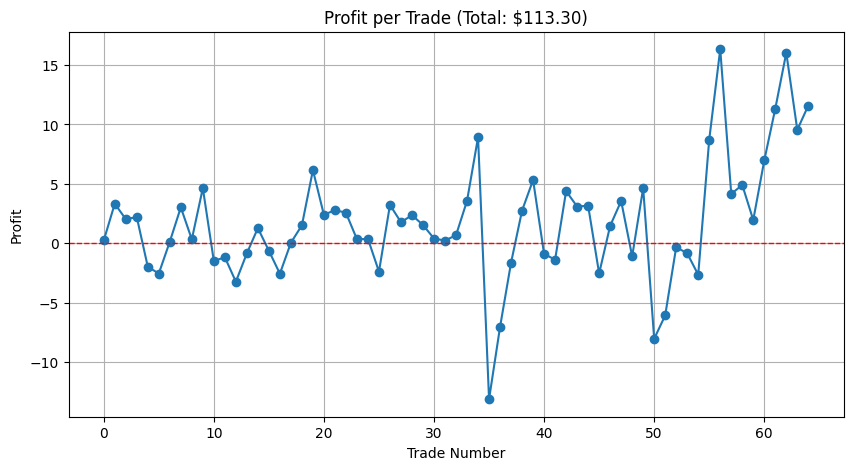

In [16]:
if __name__ == "__main__":
    stock_file = "AAPL.csv"
    window_size = 10
    episodes = 2
    batch_size = 16

    trade_profits, total_profit = train_agent(stock_file, window_size, episodes, batch_size)
    plot_profit(trade_profits, total_profit)

### **Baseline: Moving Average Crossover Strategy**

This block implements a simple moving average (SMA) crossover strategy, one of the traditional rule-based approaches to trading. It serves as a baseline to compare against the reinforcement learning agent.

How it works

* Two moving averages of the stock’s closing price are calculated:

  * Short-term SMA (e.g., 10-day average).
  * Long-term SMA (e.g., 50-day average).
* Trading signals:

  * Buy when the short-term SMA crosses above the long-term SMA (bullish signal).
  * Sell when the short-term SMA crosses below the long-term SMA (bearish signal).

Mathematical aspect

* Short-term SMA

  $$
  SMA_{short}(t) = \frac{P_t + P_{t-1} + \dots + P_{t-n+1}}{n}
  $$

* Long-term SMA

  $$
  SMA_{long}(t) = \frac{P_t + P_{t-1} + \dots + P_{t-m+1}}{m}, \quad (n < m)
  $$

* Trading signals are generated when:

  $$
  SMA_{short}(t) > SMA_{long}(t) \quad \text{(Buy)}  
  $$

  $$
  SMA_{short}(t) < SMA_{long}(t) \quad \text{(Sell)}  
  $$

Use for comparison

This strategy follows fixed rules and does not involve any learning.
By comparing its performance with the RL agent, we can evaluate whether reinforcement learning offers a meaningful advantage over traditional methods.



In [24]:
def moving_average_crossover_strategy(stock_file: str, short_window: int = 10, long_window: int = 50):
    """
    A simple moving average (SMA) crossover baseline strategy.
    - Buy when short-term SMA crosses above long-term SMA (bullish crossover).
    - Sell when short-term SMA crosses below long-term SMA (bearish crossover).
    Returns trade metrics for comparison with the RL agent.
    """
    import pandas as pd

    # Load stock data with explicit date format (YYYY-MM-DD)
    data = pd.read_csv(
        stock_file,
        index_col=0,
        parse_dates=[0],
        date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d", errors="coerce")
    )

    # Ensure Close column is numeric
    data["Close"] = pd.to_numeric(data["Close"], errors="coerce")
    data = data.dropna(subset=["Close"])

    # Calculate moving averages
    data["SMA_short"] = data["Close"].rolling(window=short_window).mean()
    data["SMA_long"] = data["Close"].rolling(window=long_window).mean()

    # Generate buy/sell signals safely with .loc
    data["Signal"] = 0
    data.loc[data.index[short_window:], "Signal"] = (
        (data["SMA_short"].iloc[short_window:] > data["SMA_long"].iloc[short_window:]).astype(int)
    )
    data["Position"] = data["Signal"].diff()

    # Simulate trades
    inventory = []
    trade_profits = []
    total_profit = 0

    for i in range(len(data)):
        price = data["Close"].iloc[i]
        if data["Position"].iloc[i] == 1:  # Buy signal
            inventory.append(price)
        elif data["Position"].iloc[i] == -1 and inventory:  # Sell signal
            buy_price = inventory.pop(0)
            profit = price - buy_price
            trade_profits.append(profit)
            total_profit += profit

    # Metrics
    num_trades = len(trade_profits)
    avg_profit = total_profit / num_trades if num_trades > 0 else 0
    wins = sum(1 for p in trade_profits if p > 0)
    win_rate = (wins / num_trades * 100) if num_trades > 0 else 0

    return {
        "trades": num_trades,
        "total_profit": total_profit,
        "avg_profit": avg_profit,
        "win_rate": win_rate,
        "trade_profits": trade_profits
    }


In [25]:
baseline = moving_average_crossover_strategy(stock_file)

/tmp/ipython-input-817400532.py:11: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv(


In [26]:
print(baseline)

{'trades': 2, 'total_profit': np.float64(34.05023193359375), 'avg_profit': np.float64(17.025115966796875), 'win_rate': 50.0, 'trade_profits': [np.float64(38.427452087402344), np.float64(-4.377220153808594)]}
